In [1]:
import hmc_tomography
from hmc_tomography.Samplers import HMC
import numpy

/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/__init__.py:38: UserWarning: Couldn't find the required package for ElasticFullWaveform2D. Detailed errormessage: No module named '__psvWave_cpp'
  f"Couldn't find the required package for ElasticFullWaveform2D. Detailed error"


# Tutorial 2 - Separate priors per dimension

Sometimes the parameters that we try to infer are sufficiently different such that we can't describe our prior knowledge using only one type of distribution. For example, trying to find an Earthquake hypocenter and origin time might mean that we have a Gaussian prior on its depth, but no clear preference of the origin time (as an Earthquake might of course occur anytime, before the observed arrival times at least).

The HMCTomo package has a simple interface for doing this:
1. We create the priors for all relevant parameter groups separately;
2. We combine these distributions using `hmc_tomography.Distributions.CompositeDistribution`. This leaves the order in which the distributions intact;
3. We use the resulting distribution as a prior or directly sample on it, i.e. what we would normally do with a prior.

Below we illustrate the process.

Create prior 1, a Normal distribution on one dimension.

In [2]:
prior_1 = hmc_tomography.Distributions.Normal(
    means=numpy.ones((1, 1)),
    covariance=4 * numpy.ones((1, 1)),
)

Create prior 2, a two dimensional Laplace distribution with zero mean and unit dispersion.

In [3]:
prior_2 = hmc_tomography.Distributions.Laplace(
    means=numpy.zeros((2, 1)), dispersions=numpy.ones((2, 1))
)

Combine the priors

In [4]:
prior = hmc_tomography.Distributions.CompositeDistribution([prior_1, prior_2])

<div class="alert alert-info">
<b>Note:</b> Throughout this notebook, we'll sample various distributions. Tuning settings are updated accordingly, but not discussed. Keep this in mind when playing around with the notebook; you might need to update parameters, primarily step lengths.
</div>

<div class="alert alert-info">
<b>Note:</b>
   
When combining e.g. distribution on parameter 1 and parameter 2 in this way, the function `CompositeDistribution` returns the following mathematical construct:
    
$$
\chi_\text{total} (m_1, m_2)= \chi_{m_1} (m_1) + \chi_{m_2} (m_2)
$$

where the various $\chi$'s represent negative logarithms of probabilities (misfit functions).
    
    
The gradient of the constructed misfit function is subsequently defined as:
    
$$
\frac{\partial \chi_\text{total}}{\partial \mathbf{m}} (m_1, m_2)= 
\begin{pmatrix} \frac{\partial \chi_{m_1}}{\partial m_1} (m_1) \\ \frac{\partial \chi_{m_2}}{\partial m_2} (m_2)  \end{pmatrix}.
$$
    
This is constructed automatically.
   
</div>


Create the sampler object and sample using a unit mass matrix.

In [5]:
filename = "bin/2/composite.h5"

HMC().sample(
    filename,
    prior,
    mass_matrix=hmc_tomography.MassMatrices.Unit(prior.dimensions),
    proposals=10000,
    stepsize=0.5,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin/2/composite.h5) if it exists.


Tot. acc rate: 0.00. Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Visualize the resulting samples.

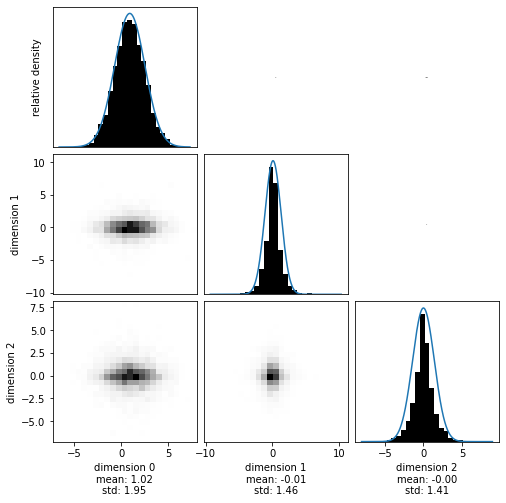

In [6]:
with hmc_tomography.Samples(filename) as samples:
    hmc_tomography.Visualization.marginal_grid(samples, [0, 1, 2], show=True)

Perfect! The posterior has (almost to machine precision) zero correlation. This si exactly what we expect, as we haven't introduced any in our prior. Additionally, the marginals perfectly capture the different distributions.

Try to get a feeling of convergence:

/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Visualization.py:266: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  color=color_1d,


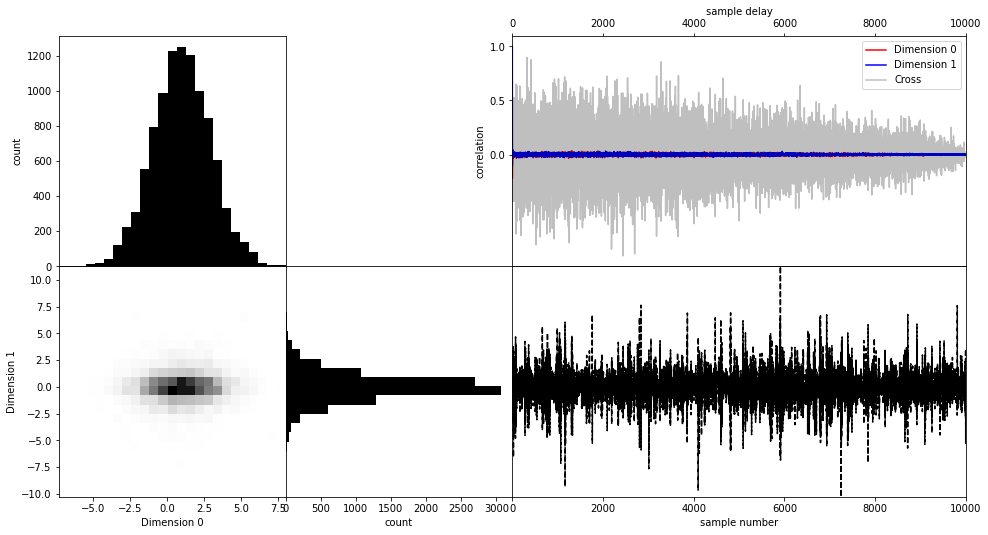

In [7]:
with hmc_tomography.Samples(filename) as samples:
    hmc_tomography.Visualization.visualize_2_dimensions(samples)